# Predicting Customer Satisfaction - Ecommerce Data
Olist has released a dataset of 100k orders made between 2016 and 2018. Lets create a model to predict what's the score a customer will give for an order.

# 1. Exploratory Data Analysis
Some **EDAs (Exploratory Data Analysis)** were already made by other users and are publicly available at the dataset's kernels. That's why we're going to skip much of the EDA and jump into the problem[](http://). We recommend the following EDAs:
* [E-Commerce Exploratory Analysis](https://www.kaggle.com/jsaguiar/e-commerce-exploratory-analysis) by [Aguiar](https://www.kaggle.com/jsaguiar)
* [Data Cleaning, Viz and Stat Analysis on e-com](https://www.kaggle.com/goldendime/data-cleaning-viz-and-stat-analysis-on-e-com) by [Azim Salikhov](https://www.kaggle.com/goldendime)

Those analysis help us understand what is happening with data. After we are confortable with it, and confident of its value we may start working on bigger problems. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

orders = pd.read_csv('olist_public_dataset_v2.csv')

# converting to datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders.order_purchase_timestamp)
orders['order_aproved_at'] = pd.to_datetime(orders.order_aproved_at).dt.date  
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date).dt.date  
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date).dt.date  

# get translations for category names
translation = pd.read_csv('product_category_name_translation.csv')
orders = orders.merge(translation, on='product_category_name').drop('product_category_name', axis=1)

orders.head(3)

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,...,product_description_lenght,product_photos_qty,product_id,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name_english
0,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1,1,2017-01-31 17:19:01,2017-02-01,2017-03-15,2017-02-06,...,625,1,6cdd53843498f92890544667809f1595,b95df3cef5297e79ef709ba256518f6f,5,NaN,NaN,2017-02-07 00:00:00.000000,2017-02-09 02:37:37+00:00,health_beauty
1,e98077a0d199a25a40eab3b14cc230d4,delivered,39.99,15.23,1,2,2018-04-17 13:25:36,2018-04-18,2018-05-10,2018-04-27,...,405,2,190d9562bfbe9d3ed876c2ac6f2f5894,e98077a0d199a25a40eab3b14cc230d4,5,NaN,NaN,2018-04-28 00:00:00.000000,2018-04-29 21:07:53+00:00,health_beauty
2,8a723730400b508cbf47fbef4a76ec8e,delivered,60.00,20.91,1,1,2018-02-18 12:41:01,2018-02-18,2018-03-14,2018-03-03,...,1665,1,5858f45c20fde7d7e49af37a2166635a,8a723730400b508cbf47fbef4a76ec8e,5,NaN,muito bom cabelo fica lisinho,2018-03-04 00:00:00.000000,2018-03-07 02:53:50+00:00,health_beauty


# 2. Defining the Problem
Let's say your manager asked you: 

**"What is the probable score that we getting from customers?"**

Our problem is to find a way to estimate, based on data about the product and order, what will be the customer review score.

# 3. The hypothesis
Our main hypothesis is that the product and how the order was fulfilled might influence the customer review score. Keep in mind that each feature we create is a new hypothesis we are testing.

# 4. Designing an Experiment
To answer that question we must implement collect data from each order up to delivery phase. With that, we should implement a model that estimates what will be the score given by the customer at the review phase.

![frame the problem](https://i.imgur.com/MTLzY55.png)

####  How would you frame this problem? 
If you would try a different approach, please leave a comment or write a kernel!


# a. Drop columns
Some columns have information about the review given by a customer (review_coment_message, review_creation_date, etc), but we don't want to use that. Our experiment assumes we don't have any information about the review, so we need to predict the score before a customer writes it. There are also some columns that are unninformative to predict the customer satisfaction.

In [2]:
orders = orders[['order_status', 'order_products_value',
                 'order_freight_value', 'order_items_qty', 'order_sellers_qty',
                 'order_purchase_timestamp', 'order_aproved_at', 'order_estimated_delivery_date', 
                 'order_delivered_customer_date', 'customer_state', 
                 'product_category_name_english', 'product_name_lenght', 'product_description_lenght', 
                 'product_photos_qty', 'review_score']]

# b. Spliting the Dataset
It is important that we split our data at the very beginning of our analysis. Doing that after might introduce some unwanted bias. 

> To split correctly, lets first see how classes are distributed over the full dataset.

In [3]:
# We keep the same proportion of classes
orders['review_score'].value_counts() / len(orders['review_score'])

5    0.56693
4    0.19247
1    0.11905
3    0.08743
2    0.03412
Name: review_score, dtype: float64

## Simple split
Lets first try a simple random split and lets see if the proportions are kept equal.

In [4]:
from sklearn.model_selection import train_test_split

# split
train_set, test_set = train_test_split(orders, test_size=0.2, random_state=42)

In [5]:
test_set['review_score'].value_counts() / len(test_set['review_score'])

5    0.56645
4    0.19320
1    0.12195
3    0.08530
2    0.03310
Name: review_score, dtype: float64

We see there is some difference between the proportion of each class compared to the original dataset.

## Stratified Split
Now lets do a stratified shuffle split and compare to the full dataset again.

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

# Stratified Split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(orders, orders['review_score']):
    strat_train_set = orders.loc[train_index]
    strat_test_set = orders.loc[test_index]

In [7]:
strat_train_set['review_score'].value_counts() / len(strat_train_set['review_score'])

5    0.566925
4    0.192475
1    0.119050
3    0.087425
2    0.034125
Name: review_score, dtype: float64

By doing a stratified split we keep the same proportion between classes. This split better represent the original data and will possibli reduce any bias. 

# c. Separate Labels From Features
We don't wanto to apply any transformation to the labels (review_score). To avoid that we just create a separate serie with labels, and drop the target column from features dataset.

In [8]:
orders_features = strat_train_set.drop('review_score', axis=1)
orders_labels = strat_train_set['review_score'].copy()

# d. Feature Engineering
If we see the original data there aren't many columns that are correlated to target.

In [9]:
corr_matrix = strat_train_set.corr()
corr_matrix['review_score'].sort_values(ascending=False)

/var/folders/89/0r9qyh0n08b8ytzm9swqrl_80000gn/T/ipykernel_23441/81064377.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = strat_train_set.corr()


review_score                  1.000000
product_photos_qty            0.017596
product_description_lenght    0.014032
product_name_lenght          -0.007707
order_products_value         -0.020501
order_freight_value          -0.071941
order_items_qty              -0.073601
order_sellers_qty            -0.137920
Name: review_score, dtype: float64

It's clear that we have to create more informative features to model this problem.

## Features Hypotesis

#### Working Days Estimated Delivery Time
Gets the days between order approval and estimated delivery date. A customer might be unsatisfied if he is told that the estimated time is big.

#### Working Days Actual Delivery Time
Gets the days between order approval and delivered customer date. A customer might be more satisfied if he gets the product faster.

#### Working Days Delivery Time Delta
The difference between the actual and estimated date.  If negative was delivered early, if positive was delivered late. A customer might be more satisfied if the order arrives sooner than expected, or unhappy if he receives after the deadline

#### Is Late
Binary variable indicating if the order was delivered after the estimated date.

#### Average Product Value
Cheaper products might have lower quality, leaving customers unhappy.

#### Total Order Value
If a customer expends more, he might expect a better order fulfilment.

#### Order Freight Ratio
If a customer pays more for freight, he might expect a better service.

#### Purchase Day of Week
Does it affect how happy are the customers?

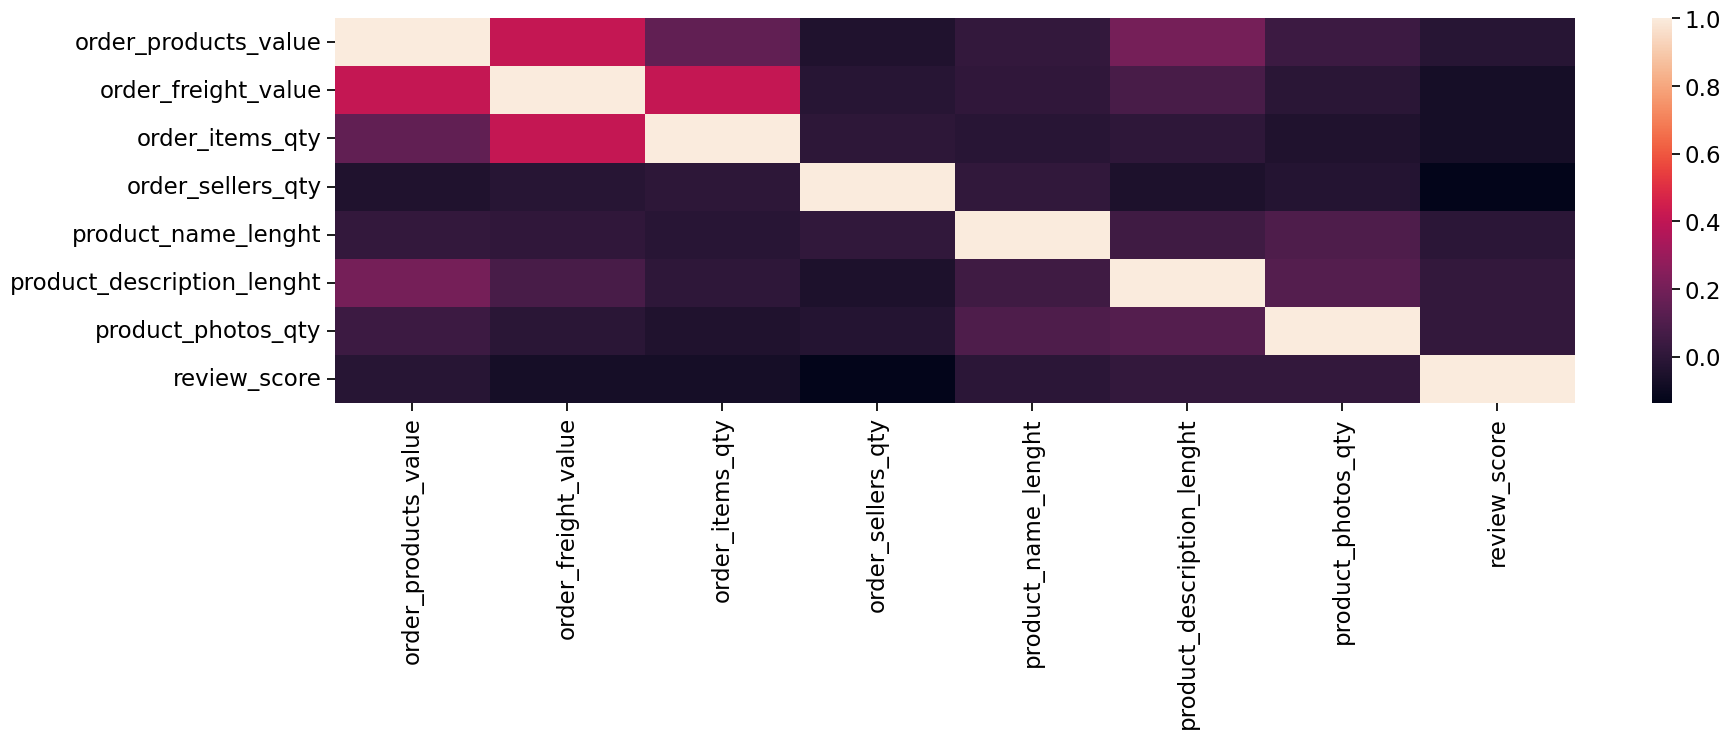

In [10]:
plt.figure(figsize=(20,5))
sns.heatmap(corr_matrix)
plt.show()

In [11]:
# To consider Brazilian calendar and hollidays
from workalendar.america import Brazil
cal = Brazil()

## Creating a Custom Transformer for FeatEng
We need to guarantee that we are apply exactly the same transformation to new/unseen data. To do that we will create custom transformers using scikit-learn BaseEstimator.

This first custom transformer will do the feature engineering that we just described earlier.

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        
        # Calculate the estimated delivery time and actual delivery time in working days. 
        # This would allow us to exclude hollidays that could influence delivery times.
        # If the order_delivered_customer_date is null, it returns 0.
        df['wd_estimated_delivery_time'] = df.apply(lambda x: cal.get_working_days_delta(x.order_aproved_at, 
                                                                                      x.order_estimated_delivery_date), axis=1)
        df['wd_actual_delivery_time'] = df.apply(lambda x: cal.get_working_days_delta(x.order_aproved_at, 
                                                                                   x.order_delivered_customer_date), axis=1)

        # Calculate the time between the actual and estimated delivery date. If negative was delivered early, if positive was delivered late.
        df['wd_delivery_time_delta'] = df.wd_actual_delivery_time - df.wd_estimated_delivery_time


        # Calculate the time between the actual and estimated delivery date. If negative was delivered early, if positive was delivered late.
        df['is_late'] = df.order_delivered_customer_date > df.order_estimated_delivery_date
        
        # Calculate the average product value.
        df['average_product_value'] = df.order_products_value / df.order_items_qty

        # Calculate the total order value
        df['total_order_value'] = df.order_products_value + df.order_freight_value
        
        # Calculate the order freight ratio.
        df['order_freight_ratio'] = df.order_freight_value / df.order_products_value
        
        # Calculate the order freight ratio.
        df['purchase_dayofweek'] = df.order_purchase_timestamp.dt.dayofweek
                       
        # With that we can remove the timestamps from the dataset
        cols2drop = ['order_purchase_timestamp', 'order_aproved_at', 'order_estimated_delivery_date', 
                     'order_delivered_customer_date']
        df.drop(cols2drop, axis=1, inplace=True)
        
        return df

### New Features - Working Days
Analysing the dataframe we see that the new features were succesfully created.

In [13]:
# Check Data Types
print(strat_train_set[['order_aproved_at', 'order_estimated_delivery_date']].dtypes)

# Handle Missing Values
print(strat_train_set[['order_aproved_at', 'order_estimated_delivery_date']].isnull().sum())

# Inspect Problematic Rows
problematic_rows = strat_train_set[strat_train_set['order_aproved_at'].isnull() | strat_train_set['order_estimated_delivery_date'].isnull()]
print(problematic_rows[['order_aproved_at', 'order_estimated_delivery_date']])

order_aproved_at                 object
order_estimated_delivery_date    object
dtype: object
order_aproved_at                 15
order_estimated_delivery_date     0
dtype: int64
      order_aproved_at order_estimated_delivery_date
73317              NaT                    2017-03-20
20149              NaT                    2017-03-03
32192              NaT                    2017-03-29
56136              NaT                    2017-03-21
52907              NaT                    2017-03-27
83464              NaT                    2017-03-20
8819               NaT                    2017-03-23
37264              NaT                    2017-03-28
18814              NaT                    2017-03-23
30217              NaT                    2017-03-27
37639              NaT                    2017-03-22
29611              NaT                    2017-03-16
1690               NaT                    2016-10-07
1792               NaT                    2017-03-31
93241              NaT    

In [14]:
strat_train_set['order_aproved_at'] = pd.to_datetime(strat_train_set['order_aproved_at'])
strat_train_set['order_estimated_delivery_date'] = pd.to_datetime(strat_train_set['order_estimated_delivery_date'])
strat_train_set.dropna(subset=['order_aproved_at'], inplace=True)

In [15]:
# Executing the estimator we just created
attr_adder = AttributesAdder()
feat_eng = attr_adder.transform(strat_train_set)
feat_eng.head(3)

/Users/devarasumanth/anaconda3/lib/python3.11/site-packages/workalendar/core.py:862: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable.
  if start > end:
/Users/devarasumanth/anaconda3/lib/python3.11/site-packages/workalendar/core.py:872: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable.
  while start < end:


,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,customer_state,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,review_score,wd_estimated_delivery_time,wd_actual_delivery_time,wd_delivery_time_delta,is_late,average_product_value,total_order_value,order_freight_ratio,purchase_dayofweek
41966,delivered,45.9,8.72,1,1,SP,sports_leisure,39,772,1,5,8,5,-3,False,45.9,54.62,0.189978,0
62325,delivered,45.0,17.25,1,1,BA,watches_gifts,56,660,3,5,12,14,2,True,45.0,62.25,0.383333,3
7720,delivered,89.9,15.70,1,1,SP,health_beauty,49,819,3,5,22,2,-20,False,89.9,105.60,0.174638,3


### Correlation
What is the correlation of the features we have just created with the review score?

In [16]:
corr_matrix = feat_eng.corr()
corr_matrix['review_score'].sort_values(ascending=False)

/var/folders/89/0r9qyh0n08b8ytzm9swqrl_80000gn/T/ipykernel_23441/1186622368.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = feat_eng.corr()


review_score                  1.000000
product_photos_qty            0.017605
product_description_lenght    0.014015
average_product_value        -0.003402
purchase_dayofweek           -0.006727
product_name_lenght          -0.007699
order_products_value         -0.020494
order_freight_ratio          -0.024030
total_order_value            -0.026797
wd_estimated_delivery_time   -0.053634
order_freight_value          -0.071957
order_items_qty              -0.073601
order_sellers_qty            -0.137925
wd_delivery_time_delta       -0.171753
wd_actual_delivery_time      -0.238283
is_late                      -0.338760
Name: review_score, dtype: float64

Looks ok, there aren't any strong correlation. But it is clear that if a customer will give a lower score if he gets an order after the estimated date. 

## Any missing values?
Let's see if there are any missing values.

In [17]:
feat_eng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79985 entries, 41966 to 97702
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_status                   79985 non-null  object 
 1   order_products_value           79985 non-null  float64
 2   order_freight_value            79985 non-null  float64
 3   order_items_qty                79985 non-null  int64  
 4   order_sellers_qty              79985 non-null  int64  
 5   customer_state                 79985 non-null  object 
 6   product_category_name_english  79985 non-null  object 
 7   product_name_lenght            79985 non-null  int64  
 8   product_description_lenght     79985 non-null  int64  
 9   product_photos_qty             79985 non-null  int64  
 10  review_score                   79985 non-null  int64  
 11  wd_estimated_delivery_time     79985 non-null  int64  
 12  wd_actual_delivery_time        79985 non-n

Great! No missing values after this transformation!

# e. Data Viz
Now let's visually explore this dataset a little bit!

# f. Dealing with Categorical and Numerical Attributes
The way we handle categorical data is very different from the transformations needed for numerical features. We will create a transformer to select only categorical or numerical features for processing.

In [18]:
# selecting the numerical and text attributes
cat_attribs = ['order_status', 'customer_state', 'product_category_name_english']
num_attribs = orders_features.drop(cat_attribs, axis=1).columns

In [19]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attribute_names]

## Numerical Attributes
Creating pipelines to handle unseen data

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# for now we wont work with categorical data. Planning to add it on next releases
num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
                         ('attribs_adder', AttributesAdder()),
                         ('std_scaller', StandardScaler())
                        ])

In [21]:
orders_features['order_aproved_at'] = pd.to_datetime(orders_features['order_aproved_at'])
orders_features['order_estimated_delivery_date'] = pd.to_datetime(orders_features['order_estimated_delivery_date'])
orders_features.dropna(subset=['order_aproved_at'], inplace=True)

In [22]:
# lets see how the resulting data looks like
orders_features_prepared = num_pipeline.fit_transform(orders_features)
orders_features_prepared

/Users/devarasumanth/anaconda3/lib/python3.11/site-packages/workalendar/core.py:862: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable.
  if start > end:
/Users/devarasumanth/anaconda3/lib/python3.11/site-packages/workalendar/core.py:872: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable.
  while start < end:


array([[-0.42866688, -0.64027556, -0.21753666, ..., -0.47358441,
        -0.37770436, -1.40776951],
       [-0.43331519, -0.22179021, -0.21753666, ..., -0.43596339,
         0.27801999,  0.1168593 ],
       [-0.20141603, -0.29783386, -0.21753666, ..., -0.22221876,
        -0.42972591,  0.1168593 ],
       ...,
       [-0.29479547,  0.79866644, -0.21753666, ..., -0.20116479,
         0.77472059,  1.1332785 ],
       [-0.14976811, -0.07264655, -0.21753666, ..., -0.15028025,
        -0.33319398, -1.40776951],
       [-0.40800771, -0.18646671, -0.21753666, ..., -0.40825301,
         0.19929753,  1.64148811]])

# g. Selecting a Model
Start simple.

## Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(orders_features_prepared, orders_labels)

ValueError: Found input variables with inconsistent numbers of samples: [79985, 80000]

In [24]:
some_data = orders_features.iloc[:8]
some_labels = orders_labels.iloc[:8]
some_data_prepared = num_pipeline.transform(some_data)

In [25]:
print('Predicted: {} \n Labels: {}'.format(list(lin_reg.predict(some_data_prepared)), list(some_labels.values)))

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Looks like we are not even close to predicting the right values. Lets see whats the root mean squared error.

In [34]:
from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(orders_features_prepared)
lin_mse = mean_squared_error(orders_labels, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

A typical prediction error of about 1.25 is not at all satisfying when we are trying to predict values that range from 1 to 5.  So let's try a different model.

In [35]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(orders_features_prepared, orders_labels)

predictions = forest_reg.predict(orders_features_prepared)
forest_mse = mean_squared_error(orders_labels, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

ValueError: Found input variables with inconsistent numbers of samples: [79985, 80000]

Much better! We got a typical error of 0.53 with Random Forest. Looks like it's a good algorithm! Let's see some examples of predictions.

In [36]:
print('Predicted: {} \n Labels: {}'.format(list(forest_reg.predict(some_data_prepared)), list(some_labels.values)))

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Next steps

1. Cross validation
2. Grid search
3. Full pipeline - transform and predict data
4. Validation on test set
5. Constructing a conclusion